# Tree-Based Models

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# import data
X_train = pd.read_csv('data/X_train.csv')
X_val = pd.read_csv('data/X_val.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

## Decision Tree

In [6]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)
print(confusion_matrix(y_val, dt_preds))
print(classification_report(y_val, dt_preds))

[[3835  838]
 [ 795  532]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4673
           1       0.39      0.40      0.39      1327

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000



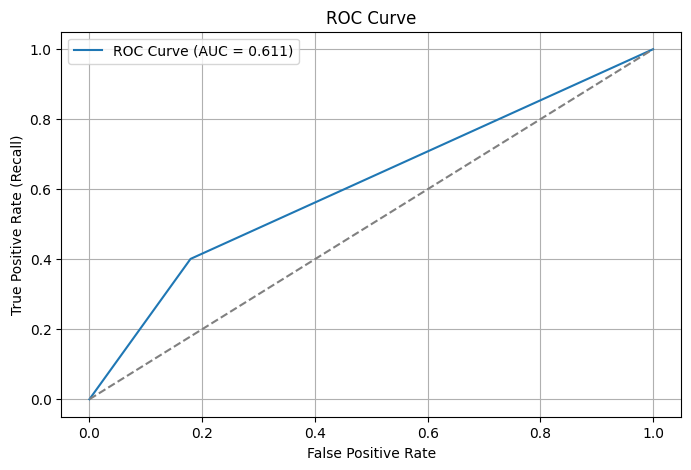

In [9]:
# Plot ROC
def plot_roc(actual, pred):
    fpr, tpr, _ = roc_curve(actual, pred)
    auc_score = roc_auc_score(actual, pred)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_roc(y_val, dt_preds)

### Hyperparameter tuning

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, 
                       cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Best parameters:", grid_dt.best_params_)
print("Best F1 score from CV:", grid_dt.best_score_)

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 score from CV: 0.49095452570480774


In [12]:
best_dt = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=2)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [13]:
# Evaluate on validation set
dt_val_preds = best_dt.predict(X_val)
print(classification_report(y_val, dt_val_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



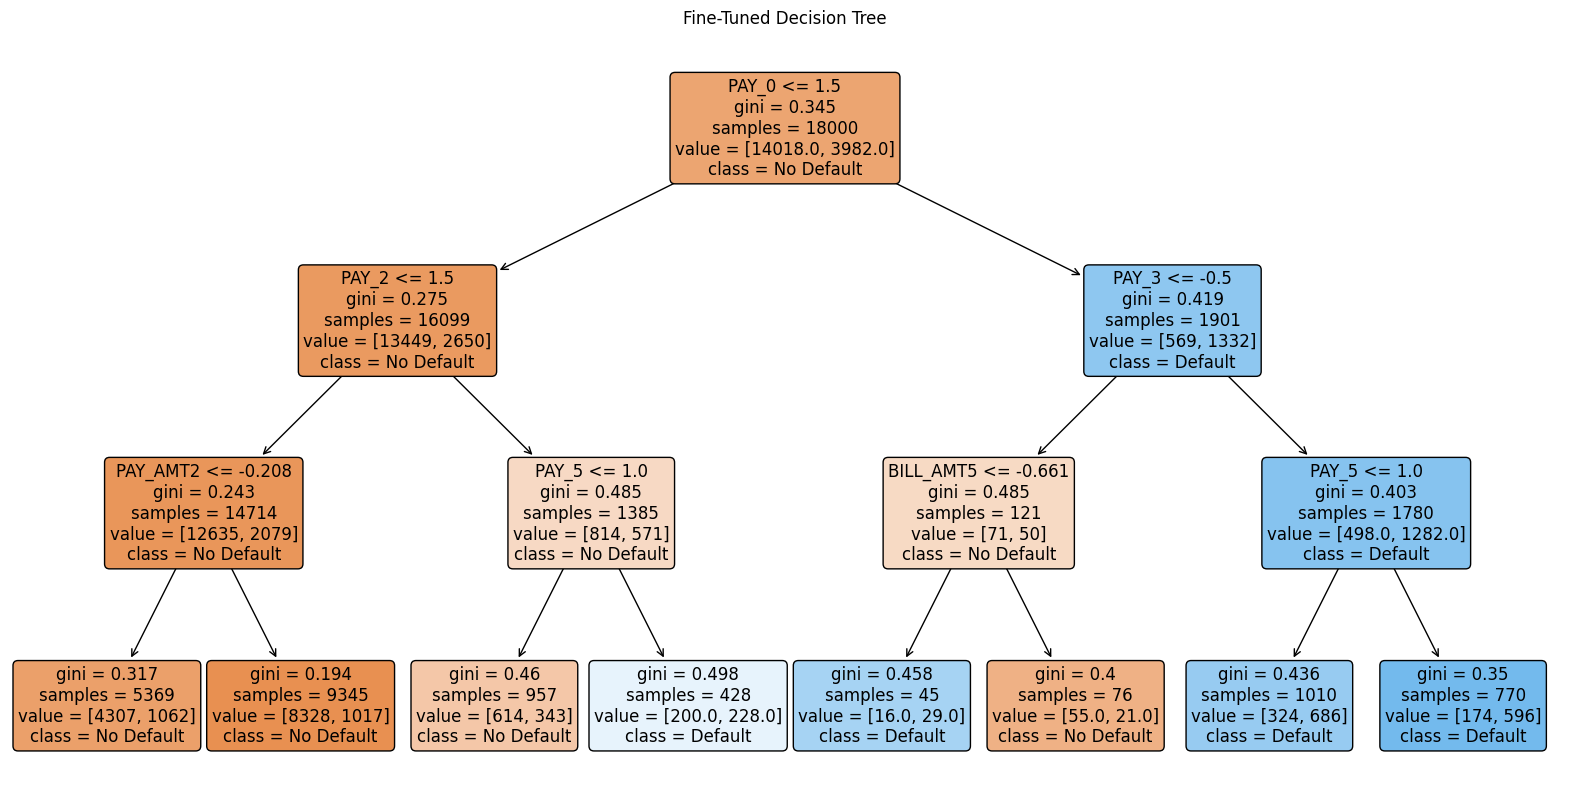

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Decision Tree")
plt.show()

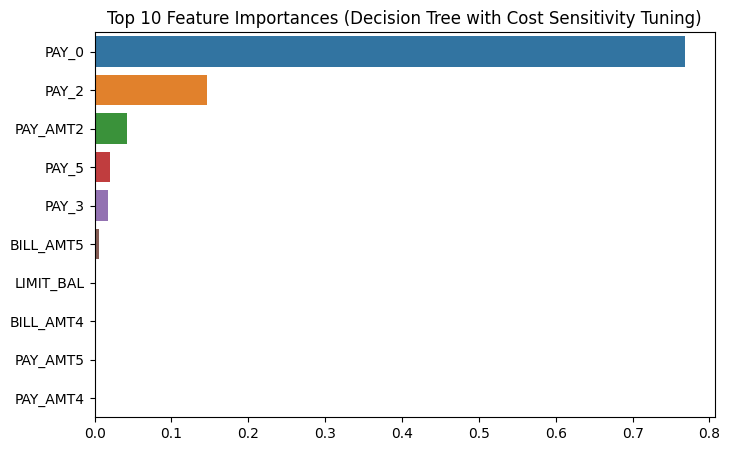

In [15]:
feature_importances = pd.Series(best_dt.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances (Decision Tree with Cost Sensitivity Tuning)")
plt.show()

### Cost sensitivity tuning


In default prediction, false negatives (failing to detect a default) are usually more costly than false positives (mistakenly flagging someone who wouldn't default). So we want the model to penalize mistakes on defaults more heavily.

In [ ]:
param_grid = {
    'class_weight': [{0:1, 1:w} for w in range(1,5)],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, 
                       cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt_ = grid_dt.best_estimator_
print("Best parameters:", grid_dt.best_params_)
print("Best F1 score from CV:", grid_dt.best_score_)

Best parameters: {'class_weight': {0: 1, 1: 3}, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best F1 score from CV: 0.5264861316242688


In [ ]:
best_dt_ = DecisionTreeClassifier(random_state=42, class_weight={0: 1, 1: 3}, 
                                  max_depth=3, # for visualization
                                  min_samples_split=20, min_samples_leaf=1)
best_dt_.fit(X_train, y_train)

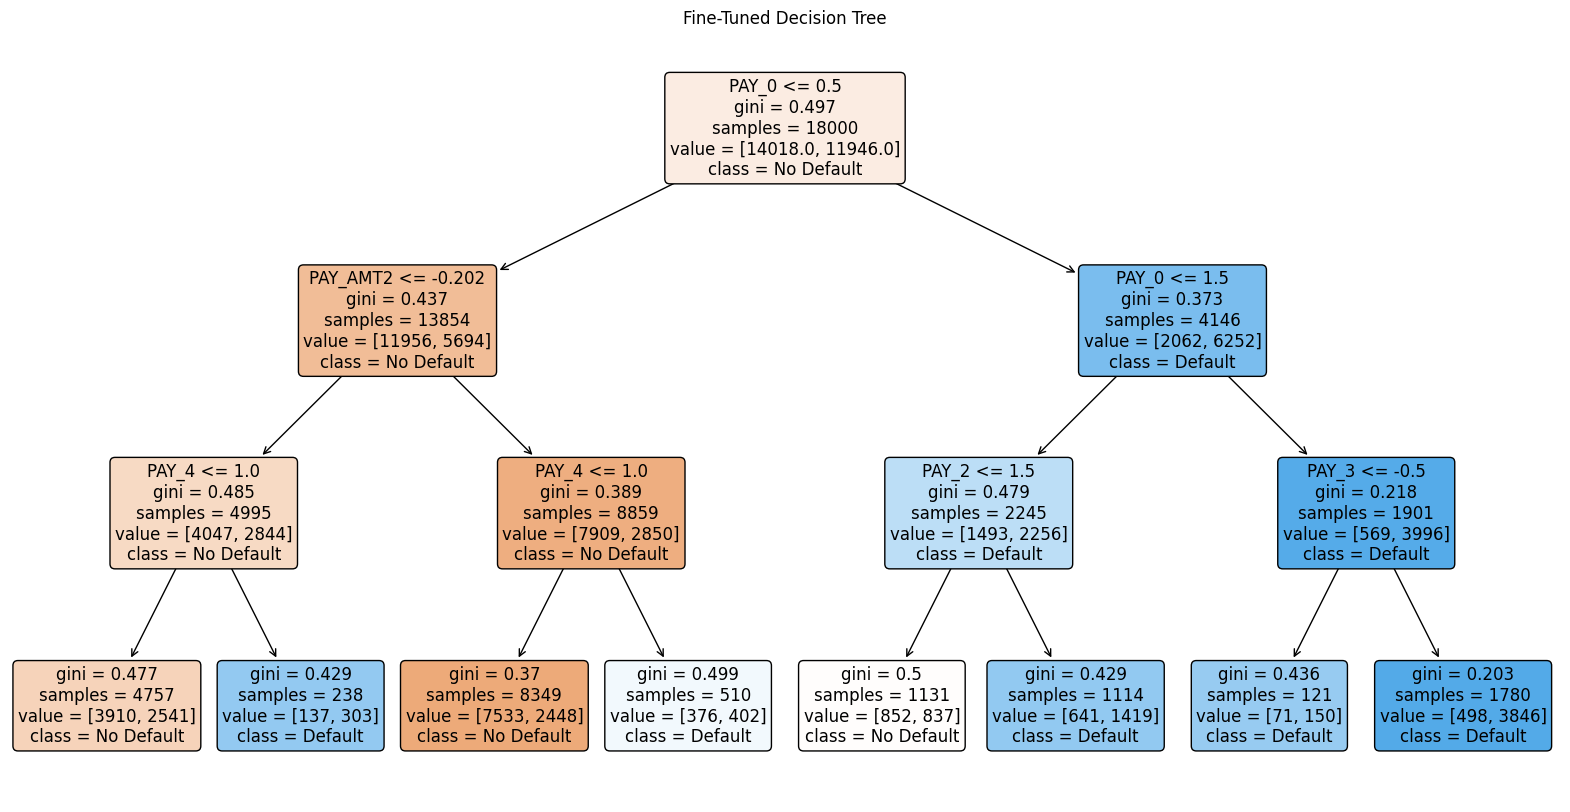

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt_, feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Decision Tree")
plt.show()

In [18]:
# Evaluate on validation set
dt_val_preds = best_dt_.predict(X_val)
print(classification_report(y_val, dt_val_preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      4673
           1       0.52      0.47      0.49      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.78      6000



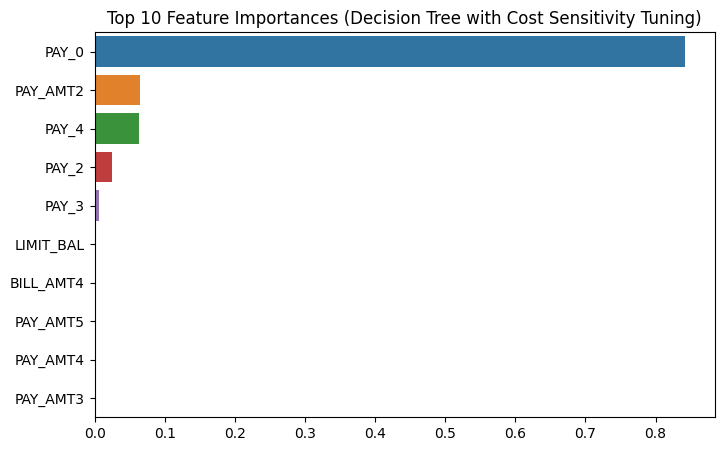

In [11]:
feature_importances = pd.Series(best_dt_.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances (Decision Tree with Cost Sensitivity Tuning)")
plt.show()

## Random Forest

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print(confusion_matrix(y_val, rf_preds))
print(classification_report(y_val, rf_preds))

c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[[4412  261]
 [ 886  441]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.63      0.33      0.43      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



### Hyperparameter Tuning

In [20]:
param_grid = {
    'class_weight': [{0:1, 1:w} for w in range(1,5)],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5],
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, 
                       cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best params:", grid_rf.best_params_)

c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best params: {'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}


In [5]:
grid_rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 3}, max_depth=10, 
                                 min_samples_leaf=5, min_samples_split=20, n_estimators=100)
grid_rf.fit(X_train, y_train)

c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=10,
                       min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [6]:
rf_preds_grid = grid_rf.predict(X_val)
print(confusion_matrix(y_val, rf_preds_grid))
print(classification_report(y_val, rf_preds_grid))

[[4105  568]
 [ 642  685]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4673
           1       0.55      0.52      0.53      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.70      0.70      6000
weighted avg       0.79      0.80      0.80      6000



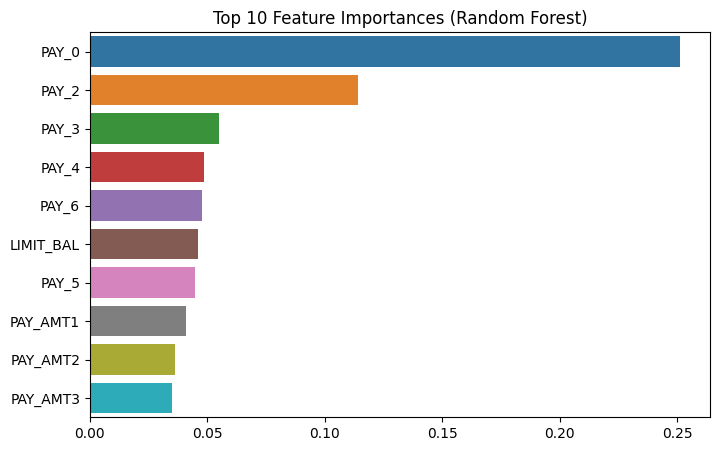

In [7]:
feature_importances = pd.Series(grid_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

## XGBoost

In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
print(confusion_matrix(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))

c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[[4394  279]
 [ 899  428]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.61      0.32      0.42      1327

    accuracy                           0.80      6000
   macro avg       0.72      0.63      0.65      6000
weighted avg       0.78      0.80      0.78      6000



### Hyperparameter Tuning

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

# Evaluate on validation set
best_xgb = grid_xgb.best_estimator_
xgb_preds = best_xgb.predict(X_val)

print("Tuned XGBoost:")
print(confusion_matrix(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))
